In [1]:
!pip install efficientnet_pytorch
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
# For accessing Google Drive
from google.colab import drive
from PIL import Image
from itertools import cycle
import os
from efficientnet_pytorch import EfficientNet

import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

import seaborn as sns

drive.mount('/content/drive')

# Set device to use gpu whenever available whether it is cuda or mps
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

### Custom Dataset Class

In [2]:
class GlaucomaDataset(Dataset):
    def __init__(self, data_dir, class_labels, transform=None):
        self.data_dir = data_dir
        self.class_labels = class_labels
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through each class folder and collect image paths and labels
        for class_label in class_labels:
            class_dir = os.path.join(data_dir, class_label)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpg', '.png')):  # Ensure image formats
                    self.image_paths.append(os.path.join(class_dir, filename))
                    self.labels.append(class_labels.index(class_label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

### TCAB

In [3]:
# Triple Channel Attention Block
class TripletChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(TripletChannelAttentionBlock, self).__init__()
        reduced_channels = in_channels // reduction_ratio

        self.branch1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_channels, kernel_size=1, stride=1, padding=0),
            nn.LayerNorm([reduced_channels, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, kernel_size=1, stride=1, padding=0),
            nn.LayerNorm([in_channels, 1, 1]),
            nn.Sigmoid()
        )

        self.branch2 = nn.Sequential(
            nn.AdaptiveAvgPool2d((in_channels, 1)),
            nn.Conv2d(in_channels, 1, kernel_size=1, stride=1, padding=0),
            nn.LayerNorm([1, in_channels, 1]),
            nn.Sigmoid()
        )

        self.branch3 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, in_channels)),
            nn.Conv2d(in_channels, 1, kernel_size=1, stride=1, padding=0),
            nn.LayerNorm([1, 1, in_channels]),
            nn.Sigmoid()
        )

        self.weights = nn.Parameter(torch.ones(3))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Handle input tensors with spatial dimensions of size 1
        if height == 1 and width == 1:
            branch1 = self.branch1(x)
            output = branch1
        else:
            branch1 = self.branch1(x).self.weights[0]
            branch2 = torch.rot90(self.branch2(torch.rot90(x, dims=(2, 3)))*self.weights[1], dims=(2, 3))
            branch3 = torch.rot90(self.branch3(torch.rot90(x, dims=(1, 2)))*self.weights[2], dims=(1, 2))

            output = branch1 +  branch2 +  branch3

        return output

### Spatial Attention Block

In [4]:
# Spatial Attention Block
class SpatialAttentionBlock(nn.Module):
    def __init__(self):
        super(SpatialAttentionBlock, self).__init__()
        # Define SAB components here
        self.conv = nn.Conv2d(2, 1, kernel_size=3, padding=1)
        self.ln = nn.LayerNorm([1, 1, 1])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through SAB
        # Compute spatial attention feature maps
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_pool, max_pool], dim=1)
        att = self.conv(concat)
        ln_out = self.ln(att)
        att = self.sigmoid(ln_out)
        x = x * att
        return x

### Cascasded Attention Network(CA-Net)

In [5]:
class CA_Net(nn.Module):
    def __init__(self, num_classes):
        super(CA_Net, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')
        num_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.TCAB = TripletChannelAttentionBlock(num_features)
        self.SAB = SpatialAttentionBlock()
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(num_features, num_classes)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # using linear classifier
        # self.classifier = nn.Linear(num_features, num_classes)
        # self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Using MultiLayerPerceptron that is better than the linear classifier that was being used
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # feature_maps = self.backbone(x)

        # # Check the shape of feature_maps
        # if len(feature_maps.size()) == 2:
        #     # If feature_maps is 2D, add singleton dimensions for height and width
        #     batch_size, channels = feature_maps.size()
        #     height, width = 1, 1
        #     feature_maps = feature_maps.view(batch_size, channels, height, width)
        # else:
        #     # If feature_maps is already 4D, unpack the dimensions
        #     batch_size, channels, height, width = feature_maps.size()

        feature_maps = self.backbone.extract_features(x)
        feature_maps = self.global_pool(feature_maps)
        Fch = self.TCAB(feature_maps)
        Fsp = self.SAB(Fch)
        Fsp = self.dropout(Fsp)
        logits = self.classifier(torch.flatten(Fsp, 1))
        return logits

### Loading the dataset and splitting it into training, testing and validation datasets

In [6]:
# Define data paths and labels
data_dir = '/content/drive/MyDrive/BTP'
class_labels = ['early_glaucoma', 'normal_control', 'advanced_glaucoma']

# Define transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Add random horizontal flipping for data augmentation
    transforms.RandomVerticalFlip(p=0.5),  # Add random vertical flipping for data augmentation
    transforms.RandomRotation(degrees=20),
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create dataset and split it into train, test and validation datasets in the ration 70:15:15
dataset = GlaucomaDataset(data_dir, class_labels, transform)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model, optimizer, and loss function
model = CA_Net(num_classes=len(class_labels)).to(device)#to device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # Add weight decay for regularization
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.5, 1.2]))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 193MB/s]


Loaded pretrained weights for efficientnet-b3


### Training

In [7]:
# Training loop
num_epochs = 100
best_val_acc = 0.0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)#to device
        optimizer.zero_grad()
        outputs = model(images)
        criterion = criterion.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)#to device
          outputs = model(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item() * images.size(0)
          _, preds = torch.max(outputs, 1)
          val_acc += (preds == labels).sum().item()
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    val_acc /= len(val_dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/100], Train Loss: 0.7307
Validation Loss: 1.2682, Validation Accuracy: 0.4615
Epoch [2/100], Train Loss: 0.6041
Validation Loss: 0.7166, Validation Accuracy: 0.7393
Epoch [3/100], Train Loss: 0.5284
Validation Loss: 0.8497, Validation Accuracy: 0.6923
Epoch [4/100], Train Loss: 0.5343
Validation Loss: 1.0259, Validation Accuracy: 0.5427
Epoch [5/100], Train Loss: 0.4817
Validation Loss: 0.6366, Validation Accuracy: 0.7564
Epoch [6/100], Train Loss: 0.4505
Validation Loss: 0.5110, Validation Accuracy: 0.7778
Epoch [7/100], Train Loss: 0.5018
Validation Loss: 0.5542, Validation Accuracy: 0.7393
Epoch [8/100], Train Loss: 0.4272
Validation Loss: 0.6011, Validation Accuracy: 0.7137
Epoch [9/100], Train Loss: 0.4704
Validation Loss: 0.4526, Validation Accuracy: 0.8120
Epoch [10/100], Train Loss: 0.4213
Validation Loss: 0.4347, Validation Accuracy: 0.7821
Epoch [11/100], Train Loss: 0.4640
Validation Loss: 0.5584, Validation Accuracy: 0.7650
Epoch [12/100], Train Loss: 0.4908
Valida

### Testing and results

In [8]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)#to device
      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

accuracy = (torch.tensor(predictions) == torch.tensor(true_labels)).float().mean().item()
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.85
Precision: 0.83
Recall: 0.84
F1-score: 0.83
Confusion Matrix:
[[36 11  3]
 [18 92  0]
 [ 3  0 73]]


### Training and Validation Loss Curves

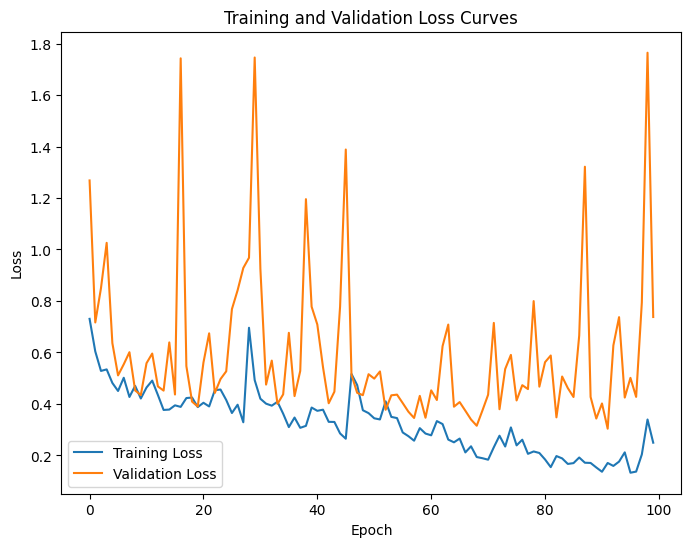

In [9]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

### Calculating Area-under-Curve(AUC) and plotting Reciever Operating Characteristic Curve(ROC CURVE)

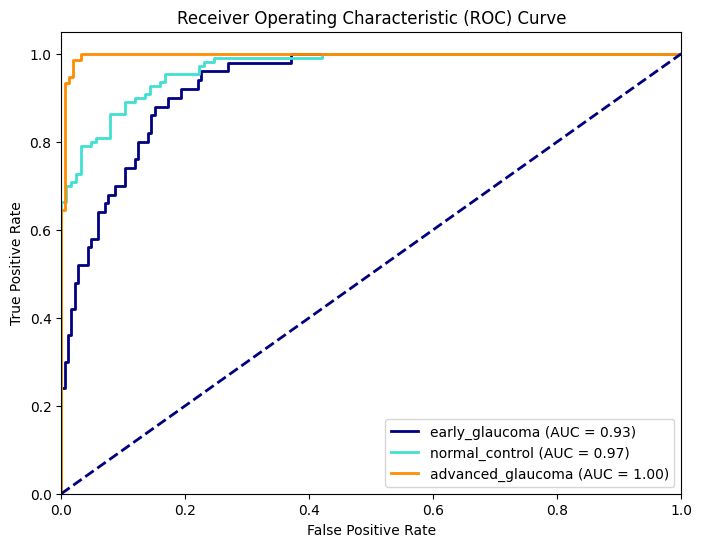

In [10]:
# Calculate ROC curve and AUC score
model.eval()
all_probabilities = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)#to device
      outputs = model(images)
      probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
      all_probabilities.extend(probabilities)
      all_labels.extend(labels.cpu().numpy())

# Compute ROC curve and AUC score for each class
n_classes = len(class_labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['navy', 'turquoise', 'darkorange'])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, [prob[i] for prob in all_probabilities])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
for i, color in zip(range(n_classes), colors):
  plt.plot(
    fpr[i],
    tpr[i],
    color=color,
    lw=lw,
    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})'
  )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

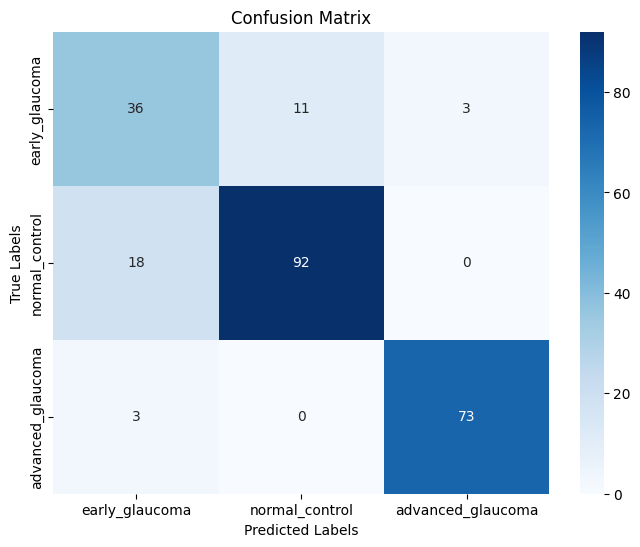

In [11]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()